<a href="https://colab.research.google.com/github/ashrikant39/Histopatgology-Image-Classification/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import math
import cv2

In [58]:
!pip install pkbar
import pkbar

In [59]:
batch_size= 32
device = 'cuda'
num_classes= 4
input_shape=(3,224,224)
layers= [3,4,6,3]
learning_rate=5e-6
num_epochs= 100

In [99]:
main_path= 'drive/My Drive/Hist_folder/KMC Dataset'
train_dir= os.path.join(main_path,'Training')
test_dir= os.path.join(main_path,'Test')
val_dir= os.path.join(main_path,'Validation')

check_pt_file= os.path.join(main_path, 'ResNet50_Checkpoint_6.pth.tar')

print(os.listdir(main_path))
print(os.listdir(train_dir))
print(os.listdir(test_dir))
print(os.listdir(val_dir))

['Training', 'Validation', 'Test', 'ResNet50_Checkpoint_1.pth.tar', 'AlexNet.ipynb', 'AlexNet_checkpoint.pth.tar', 'DenseNet.ipynb', 'ResNet50_Checkpoint_2.pth.tar', 'ResNet50_Checkpoint_3.pth.tar', 'ResNet50_Checkpoint_4.pth.tar', 'ResNet50.ipynb', 'ResNet50_Checkpoint_5.pth.tar', 'ResNet50_Checkpoint_6.pth.tar']
['grade1', 'grade3', 'grade2', 'grade0']
['grade1', 'grade0', 'grade2', 'grade3']
['grade2', 'grade1', 'grade0', 'grade3']


In [61]:
my_transforms = transforms.Compose([ #Compose makes it possible to have many transforms
    transforms.ColorJitter(brightness=0.3, contrast=0.3), # Change brightness of image
    transforms.RandomRotation(degrees=60), # Perhaps a random rotation from -45 to 45 degrees
    transforms.RandomHorizontalFlip(p=0.5), # Flips the image horizontally with probability 0.5
    transforms.RandomVerticalFlip(p=0.05), # Flips image vertically with probability 0.05
    transforms.ToTensor() # Finally converts PIL image to tensor so we can train w. pytorch
    ])


In [62]:
train_data= datasets.ImageFolder(train_dir, transform= my_transforms)
test_data= datasets.ImageFolder(test_dir, transform= transforms.ToTensor())
val_data= datasets.ImageFolder(val_dir, transform= transforms.ToTensor())

In [63]:
train_loader= DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader= DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [64]:
class_dict=train_data.class_to_idx
class_labels = class_dict.values()
print(class_labels)

dict_values([0, 1, 2, 3])


### Plotting the images with classes



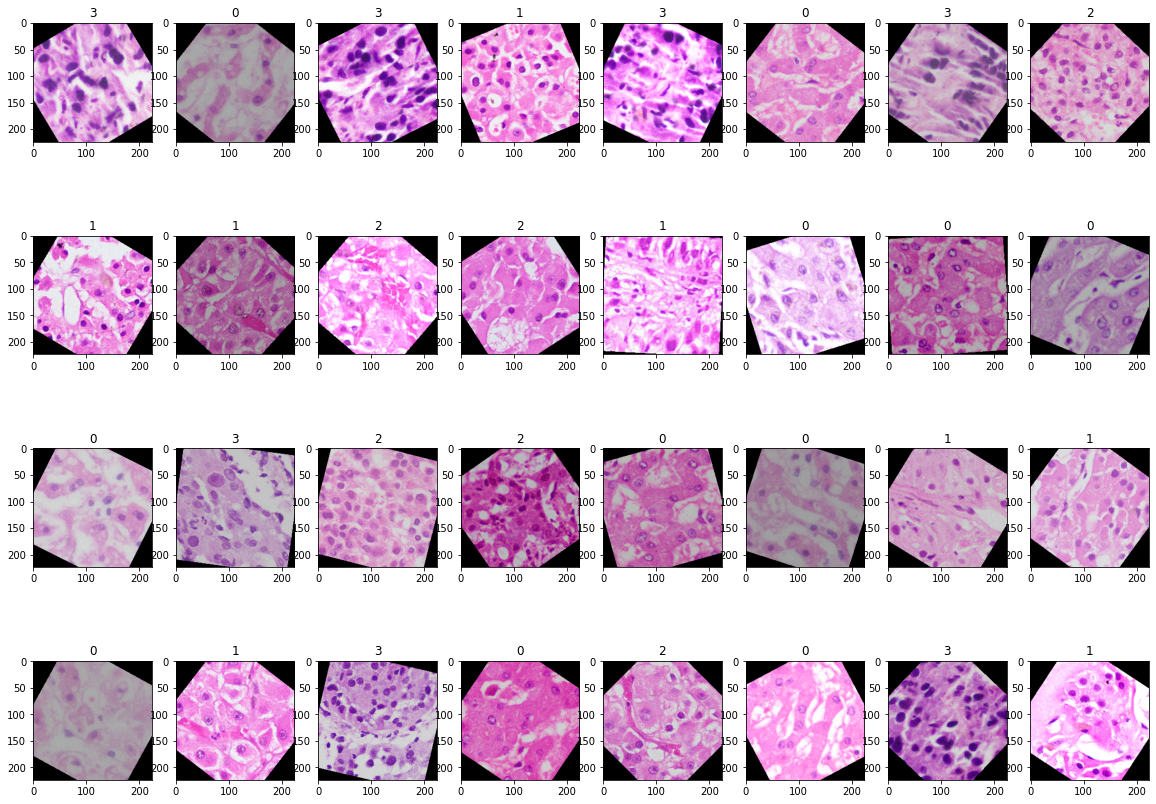

In [109]:
iterator= iter(train_loader)
it= next(iterator)
images, labels= it

plt.figure(figsize=(20,15))
for r in range(batch_size):
    plt.subplot(4,8,r+1)
    f= plt.imshow(images[r].permute(2,1,0))
    plt.title(labels[r].item())
plt.show()

In [66]:
class Residual_Block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample= None, stride=1):
    super(Residual_Block,self).__init__()
    self.expn= 4
    self.conv1= nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1= nn.BatchNorm2d(num_features=out_channels)
    self.conv2= nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2= nn.BatchNorm2d(num_features=out_channels)
    self.conv3= nn.Conv2d(in_channels= out_channels, out_channels=out_channels*self.expn, kernel_size=1, stride=1, padding=0)
    self.bn3= nn.BatchNorm2d(num_features=out_channels*self.expn)
    self.relu= nn.ReLU()
    self.identity_downsample= identity_downsample

  def forward(self,x):

    identity=x
    x= nn.Sequential(self.conv1,
                     self.bn1,
                     self.conv2,
                     self.bn2,
                     self.conv3,
                     self.bn3)(x)
    if self.identity_downsample is not None:
      identity= self.identity_downsample(identity)
    
    x-= identity
    x=self.relu(x)
    
    return x

In [67]:
class ResNet(nn.Module):
  def __init__(self, Residual_Block, layers, image_channels, num_classes):
    super(ResNet,self).__init__()
    self.in_channels=64
    self.conv1= nn.Conv2d(in_channels=image_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
    self.bn1= nn.BatchNorm2d(num_features= 64)
    self.relu= nn.ReLU()
    self.maxpool= nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer_1= self._make_layer(Residual_Block, layers[0], out_channels=64, stride=1)
    self.layer_2= self._make_layer(Residual_Block, layers[1], out_channels=128, stride=2)
    self.layer_3= self._make_layer(Residual_Block, layers[2], out_channels=256, stride=2)
    self.layer_4= self._make_layer(Residual_Block, layers[3], out_channels=512, stride=2)

    self.avgpool= nn.AdaptiveAvgPool2d((1,1))
    self.fc= nn.Linear(512*4, num_classes)

  def forward(self,x):
    x= nn.Sequential(self.conv1,
                         self.bn1,
                         self.relu,
                         self.maxpool,
                         self.layer_1,
                         self.layer_2,
                         self.layer_3,
                         self.layer_4,
                         self.avgpool)(x)
    x= x.reshape(x.shape[0], -1)
    x= self.fc(x)
    return x


  def _make_layer(self,Residual_Block, num_res_blocks, out_channels, stride):
    identity_downsample= None
    layers=[]

    if stride!=1 or self.in_channels!=out_channels*4:
      identity_downsample= nn.Sequential(nn.Conv2d(in_channels=self.in_channels,
                                                   out_channels= out_channels*4,
                                                   kernel_size=1,
                                                   stride=stride),
                                         nn.BatchNorm2d(out_channels*4))
    layers.append(Residual_Block(self.in_channels, out_channels, identity_downsample, stride))
    self.in_channels= out_channels*4

    for i in range(num_res_blocks-1):
      layers.append(Residual_Block(self.in_channels, out_channels))
    return nn.Sequential(*layers)

  

In [68]:
def ResNet50(img_channels=3, num_classes=10):
  return ResNet(Residual_Block, layers, img_channels, num_classes)

model= ResNet50(img_channels=input_shape[0], num_classes=num_classes).to(device)
summary(model, input_size= input_shape, batch_size=batch_size, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,472
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,160
       BatchNorm2d-6           [32, 64, 56, 56]             128
            Conv2d-7           [32, 64, 56, 56]          36,928
       BatchNorm2d-8           [32, 64, 56, 56]             128
            Conv2d-9          [32, 256, 56, 56]          16,640
      BatchNorm2d-10          [32, 256, 56, 56]             512
           Conv2d-11          [32, 256, 56, 56]          16,640
      BatchNorm2d-12          [32, 256, 56, 56]             512
             ReLU-13          [32, 256, 56, 56]               0
   Residual_Block-14          [32, 256,

In [69]:
Loss= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

In [70]:
def check_accuracy(scores, targets):

  num_correct=0
  num_samples=0
  _, predictions= scores.max(1)
  num_correct+= (predictions== targets).sum()
  num_samples= predictions.size(0)

  return num_correct/num_samples

In [71]:
def save_checkpoint(model, optimizer, file_name):

  checkpoint= {'state_dict': model.state_dict(),
             'optimizer_dict': optimizer.state_dict()}
  torch.save(checkpoint,file_name)

def load_checkpoint(model, optimizer, file_name):
  check_pt= torch.load(file_name)
  model.load_state_dict(check_pt['state_dict'])
  optimizer.load_state_dict(check_pt['optimizer_dict'])

  return model, optimizer

In [72]:
train_per_epoch= len(train_loader)
val_per_epoch= len(val_loader)
min_loss= math.inf
min_loss



for epoch in range(num_epochs):
  train_losses=[]
### TRAINING

  kbar_train= pkbar.Kbar(target= train_per_epoch, epoch=epoch, num_epochs=num_epochs)

  train_loop= enumerate(train_loader)
  val_loop= enumerate(val_loader)
  for batch_idx, (data,targets) in train_loop:

    model.train()

    data= data.to(device=device)
    targets= targets.to(device=device)

    # FORWARD PROP

    scores= model(data)
    train_loss= Loss(scores, targets)
    train_losses.append(train_loss.item())

    # BACKWARD PROP
    optimizer.zero_grad()
    train_loss.backward()

    optimizer.step()

    train_acc= check_accuracy(scores,targets)

    kbar_train.update(batch_idx, values=[("loss", train_loss.item()), ("accuracy", train_acc.item())])

  kbar_train.update(train_per_epoch, values=None)
### VALIDATION

  kbar_val= pkbar.Kbar(target= val_per_epoch, epoch=epoch, num_epochs=num_epochs)


  for batch_idx, (data, targets) in val_loop:

    val_losses=[]
    model.eval()

    
    data= data.to(device=device)
    targets= targets.to(device=device)
    scores= model(data)
    val_loss= Loss(scores, targets)
    val_losses.append(val_loss.item())
    val_acc= check_accuracy(scores,targets)

    kbar_val.update(batch_idx, values=[("val_loss", val_loss.item()), ("val_accuracy", val_acc.item())])

  if np.mean(val_losses)<min_loss:
    min_loss= val_loss.item()
    print('\nImproved validation loss: {:.4f}'.format(val_loss.item()))
    print('Saving the model to {}\n'.format(check_pt_file))
    save_checkpoint(model, optimizer, check_pt_file)
    
  kbar_val.update(val_per_epoch, values=None)

Epoch: 1/100
83/83 [==============================] - 47s 562ms/step - loss: 1.3523 - accuracy: 0.3134
Epoch: 1/100
8/9 [=========================>....] - ETA: 0s - val_loss: 1.3451 - val_accuracy: 0.2708
Improved validation loss: 1.3532
Saving the model to drive/My Drive/Hist_folder/KMC Dataset/ResNet50_Checkpoint_6.pth.tar

9/9 [==============================] - 3s 377ms/step - val_loss: 1.3451 - val_accuracy: 0.2708
Epoch: 2/100
83/83 [==============================] - 47s 569ms/step - loss: 1.1869 - accuracy: 0.4471
Epoch: 2/100
8/9 [=========================>....] - ETA: 0s - val_loss: 1.0735 - val_accuracy: 0.4753
Improved validation loss: 1.0533
Saving the model to drive/My Drive/Hist_folder/KMC Dataset/ResNet50_Checkpoint_6.pth.tar

9/9 [==============================] - 3s 376ms/step - val_loss: 1.0735 - val_accuracy: 0.4753
Epoch: 3/100
83/83 [==============================] - 47s 567ms/step - loss: 0.8430 - accuracy: 0.6287
Epoch: 3/100
8/9 [=========================>....] -

In [73]:
def CONFUSION_MATRIX(y_true, y_pred, class_labels, order=False):
  
  num_classes= len(class_labels)
  num_examples= len(y_true)

  if order is False:
    new_labels= np.arange(num_classes)
    
    for i in range(num_examples):
      y_true[i].item= np.where(class_labels==y_true[i])[0]
      y_pred[i].item= np.where(class_labels==y_pred[i])[0]

  mat= np.zeros((num_classes,num_classes), dtype=np.int)
  
  for i in range(num_examples):
    true= np.uint8(y_true[i].item())
    pred= np.uint8(y_pred[i].item())

    mat[true,pred]+=1

  return mat


def acc_precision_recall_f1(confusion_matrix):

  num_classes= confusion_matrix.shape[0]
  precision=      np.zeros((num_classes,1), np.float64)
  recall=         np.zeros((num_classes,1), np.float64)
  true_positives= np.zeros((num_classes,1), np.float64)
  true_negatives= np.zeros((num_classes,1), np.float64)
  accuracy=       np.zeros((num_classes,1), np.float64)
  f1=             np.zeros((num_classes,1), np.float64)

  for i in range(num_classes):
    
    true_positives[i]= confusion_matrix[i,i]
    precision[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[i])
    recall[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[:,i])
    f1[i]= 2*precision[i]*recall[i]/(precision[i]+recall[i])
  

  for i in range(num_classes):
    true_negatives[i]=0
    for j in range(num_classes):
      for k in range(num_classes):
        if (j!=i) and (k!=i):
          true_negatives[i]+=confusion_matrix[j,k]

  accuracy= (true_positives+true_negatives)/np.sum(confusion_matrix)
  return accuracy, precision, recall, f1


def Final_Metrics(loader, model, class_labels):

    model.eval()
    size= len(class_labels)
    c_mat= np.zeros((size,size), dtype= np.int)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores= model(x)
            _, preds = scores.max(1)

            c_mat+= CONFUSION_MATRIX(y, preds, class_labels, order= True)
    
    accuracy, precision, recall, f1= acc_precision_recall_f1(c_mat)

    return c_mat, accuracy, precision, recall, f1

In [100]:
resnet_50, _= load_checkpoint(model, optimizer, check_pt_file)

In [101]:
confusion_matrix, accuracy, precision, recall, f1= Final_Metrics(test_loader, resnet_50, class_labels)

In [104]:
print(confusion_matrix)

[[70  0  0  0]
 [ 0 75  5  0]
 [ 0  8 72  0]
 [ 0  0  5 45]]


In [105]:
print(precision)
print(np.mean(precision))

[[1.    ]
 [0.9375]
 [0.9   ]
 [0.9   ]]
0.934375


In [106]:
print(recall.T)
print(np.mean(recall))

[[1.         0.90361446 0.87804878 1.        ]]
0.9454158095797826


In [107]:
 print(f1.T)
 print(np.mean(f1))

[[1.         0.9202454  0.88888889 0.94736842]]
0.9391256771786316


In [108]:
print(accuracy.T)
print(np.mean(accuracy))

[[1.         0.95357143 0.93571429 0.98214286]]
0.9678571428571429
